# 1. Library Import

In [ ]:
pip install pacmap


In [ ]:
%matplotlib inline

import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리


!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import pacmap


# 2. 데이터 확인 및 전처리

In [ ]:
df_transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KB/card_transaction2.csv')

credit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KB/card.csv')


In [ ]:
df_sum = df_transactions.drop('날짜',axis=1)
df_sum = df_sum.groupby(['고객번호']).sum()

In [ ]:
df_sum

,카페,음식점,여행,서점,쇼핑,온라인결제,교통,미용실,병원,주유소,...,택시,사우나,보험,테마파크,OTT구독,배달,해외결제,대형마트,항공사,숙박
고객번호,,,,,,,,,,,,,,,,,,,,,
1,25800,334400,0,31700,487500,31600,0,73900,435400,76400,...,49800,36000,31100,178000,124900,13500,0,203500,0,0
2,57200,422500,8306220,278600,593500,112400,0,69300,261600,2200,...,32300,84800,0,40200,64300,27200,136632,268100,6723420,1582800
3,23700,441900,0,32900,0,101900,0,51700,225800,150000,...,69100,33100,177100,102400,148900,131300,0,254700,0,0
4,57400,411900,3986840,49300,529900,45100,0,268600,294700,35600,...,123800,0,152500,41400,51000,0,63254,365700,2347760,1639080
5,36500,381700,0,47800,274700,0,112000,60200,205700,42400,...,85800,90200,64300,7000,13400,102900,0,88500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,52200,425900,0,43300,42100,17900,0,53600,193700,47700,...,35700,147500,94800,84700,12600,126900,0,259600,0,0
97,14700,389900,5113170,0,722500,42700,0,64500,547300,97200,...,33700,21800,20100,109800,73600,77600,87213,133200,3014540,2098630
98,5900,430100,0,87500,0,113900,0,6500,314800,58300,...,33000,109600,89000,9600,80500,59400,0,88800,0,0


                  카페            음식점            여행            서점            쇼핑  \
count     100.000000     100.000000  1.000000e+02     100.00000  1.000000e+02   
mean    39066.000000  402710.000000  1.862756e+06   99884.00000  4.889190e+05   
std     22810.059893   39903.744033  3.490894e+06   61989.59626  2.922461e+05   
min         0.000000  309600.000000  0.000000e+00       0.00000  0.000000e+00   
25%     21575.000000  369325.000000  0.000000e+00   48025.00000  2.946250e+05   
50%     36550.000000  397700.000000  0.000000e+00   94250.00000  4.769500e+05   
75%     53450.000000  432375.000000  2.610318e+06  147750.00000  6.856000e+05   
max    108700.000000  481600.000000  1.169238e+07  278600.00000  1.225700e+06   

               온라인결제             교통            미용실             병원  \
count     100.000000     100.000000     100.000000     100.000000   
mean    73009.000000   12684.000000   70541.000000  240026.000000   
std     42158.318961   33575.137266   46861.149067  152911.5969

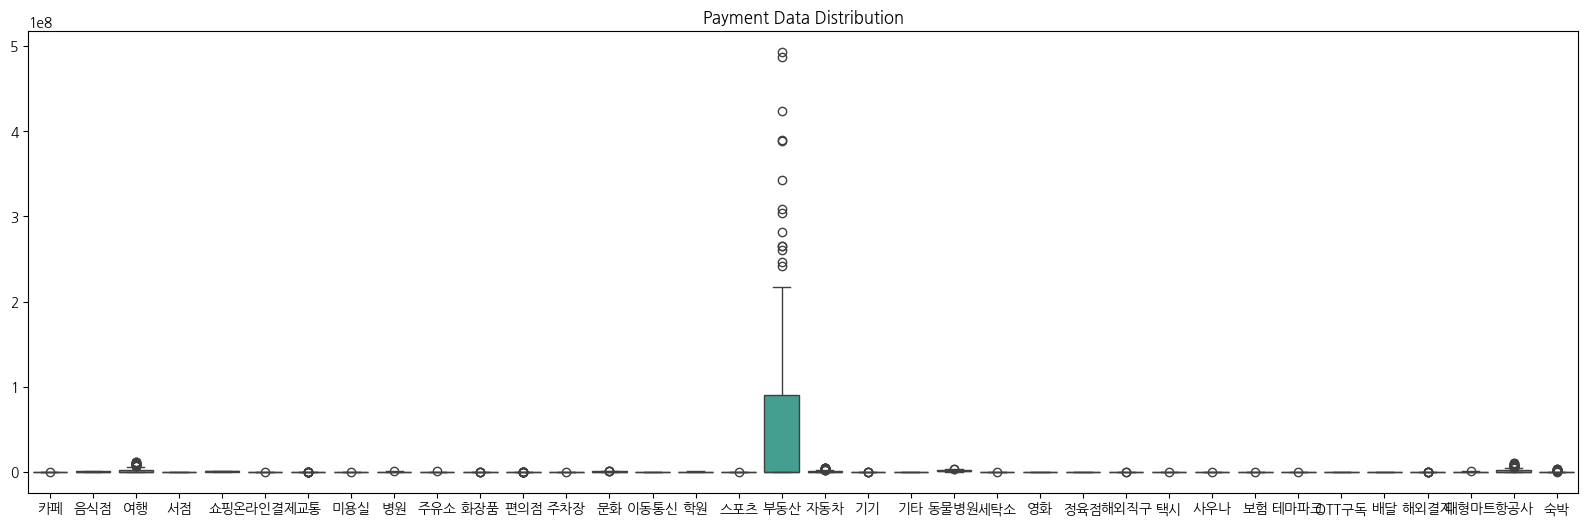

In [ ]:
# 데이터 분포 확인
print(df_sum.describe())

# 박스 플롯 그리기
plt.figure(figsize=(20,6))
sns.boxplot(data=df_sum)
plt.title("Payment Data Distribution")
plt.show()

In [ ]:
df_sum2 = df_sum.drop(['부동산','여행','자동차','항공사','기기','기타'],axis=1)


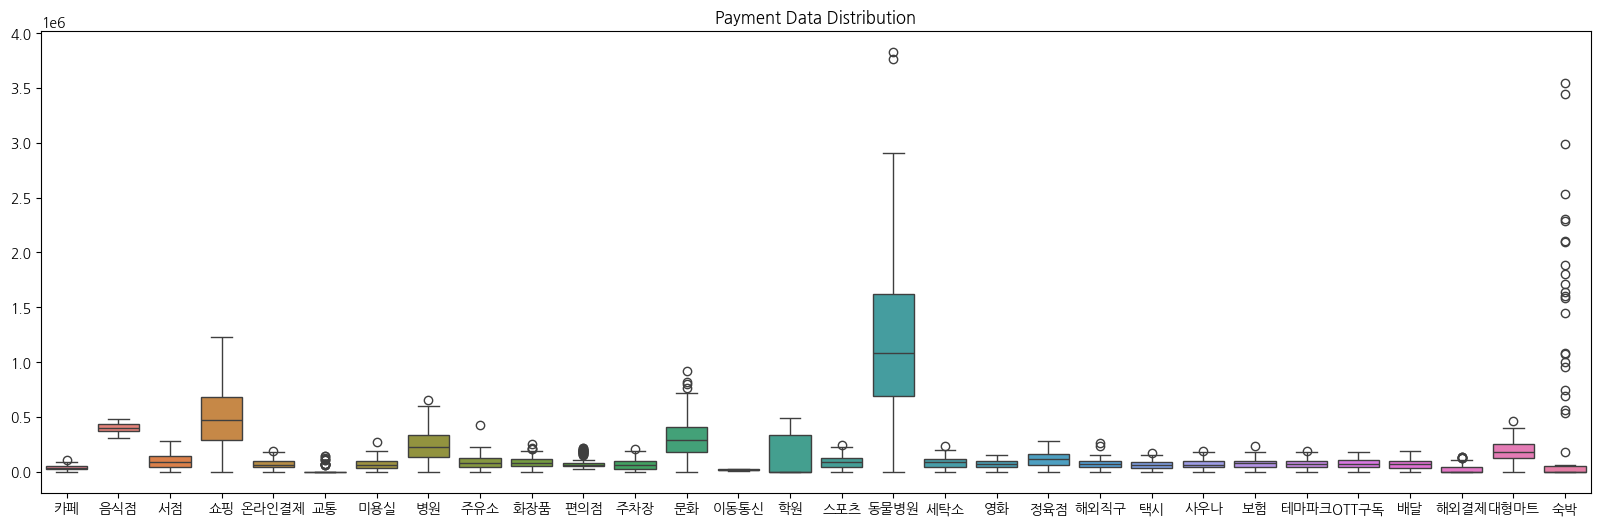

In [ ]:
# 박스 플롯 그리기
plt.figure(figsize=(20,6))
sns.boxplot(data=df_sum2)
plt.title("Payment Data Distribution")
plt.show()


# 3. 데이터 스케일링 - 표준화

In [ ]:
# 데이터 표준화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_df = scaler.fit_transform(df_sum2)

# 4. K-Means Clustering

## 4.1. PaCMAP 차원 축소

In [ ]:
# PaCMAP 객체 생성
embedding = pacmap.PaCMAP(
    n_components=2,         # 2차원으로 축소
    n_neighbors=None,       # 기본값은 None으로, 데이터에 따라 설정
    MN_ratio=0.5,          # MN 비율
    FP_ratio=2.0           # FP 비율
)

# 데이터 변환
pac_df = embedding.fit_transform(scaled_df, init="pca")

## 4.2 K-Means  
### 4.2.1 엘보우 및 실루엣 점수 확인
- **n_clusters 수 선정**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

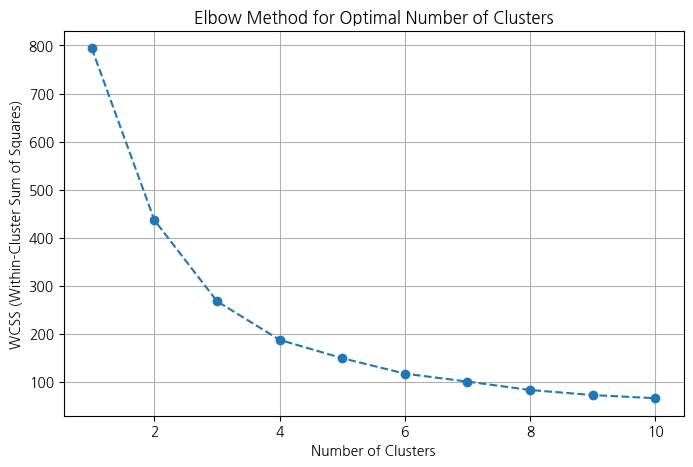

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

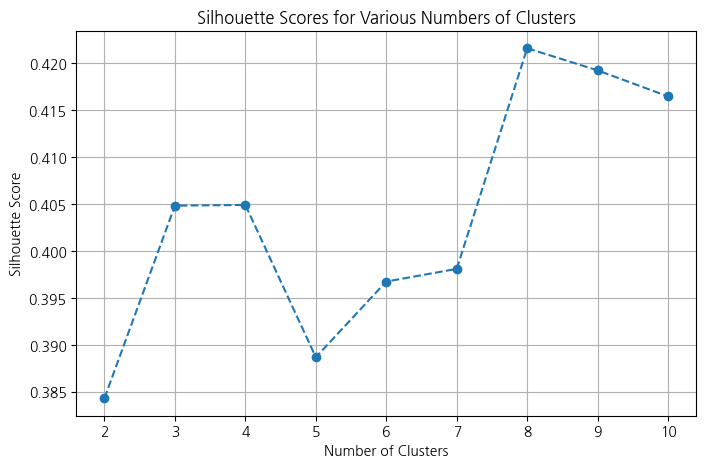

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# 엘보우 방법 적용
wcss = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(pac_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# 실루엣 점수 계산
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pac_df)
    silhouette_avg = silhouette_score(pac_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


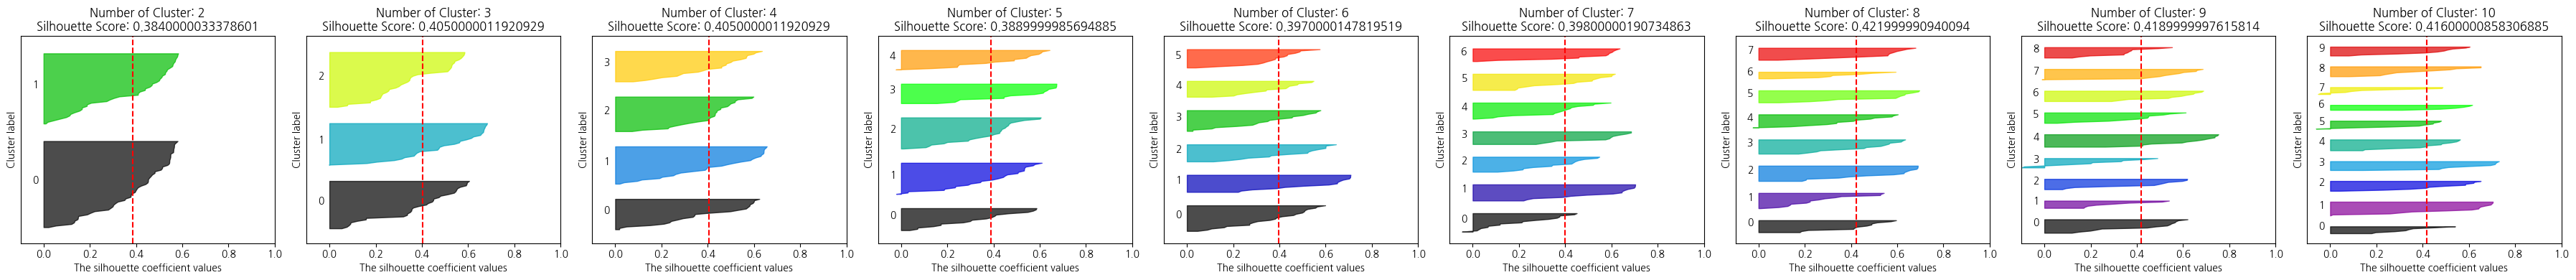

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# 데이터 표준화
# scaler = StandardScaler()
# scaled_df = scaler.fit_transform(df2)

# 클러스터 갯수를 리스트로 받아 실루엣 시각화 함수
def visualize_silhouette_kmeans(cluster_lists, X_features):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):
        # KMeans 모델 생성 및 학습
        kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_features)

        # 실루엣 점수 계산
        sil_avg = silhouette_score(X_features, cluster_labels, metric='euclidean')
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title(f'Number of Cluster: {n_cluster}\nSilhouette Score: {round(sil_avg, 3)}')
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # y축 레이블 제거
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

# 실루엣 시각화 함수 호출
visualize_silhouette_kmeans(range(2,11), pac_df)


In [ ]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*','o','s','^','x']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

## 4.2.2 K-Means Clustering  

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


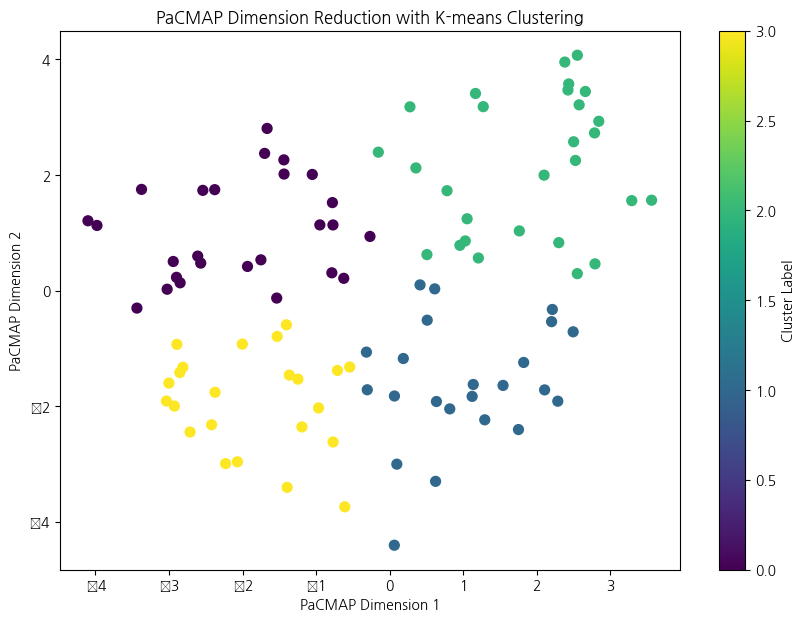

In [ ]:
from sklearn.cluster import KMeans

# K-means 클러스터링 적용
kmeans = KMeans(n_clusters=4)  # 클러스터 수를 적절히 설정하세요
clusters = kmeans.fit_predict(pac_df)

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pac_df[:, 0], pac_df[:, 1], c=clusters, cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster Label')
plt.title('PaCMAP Dimension Reduction with K-means Clustering')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.show()



# 5. 카드 선정

### 5.1. 가중치

In [ ]:
weights = {
    '교통': 1.0,
    '온라인결제' : 1.3,
    # '기기': 1.0,
    # '기타': 0.8,
    '독서실': 1.0,
    '병원': 1.1,
    '쇼핑': 1.3,
    '문화': 1.0,
    '음식점': 0.9,
    '서점': 1.2,
    '카페': 0.9,
    '여행': 1.0,
    '동물병원': 1.0,
    '영화' : 1.0,
    '스포츠' : 1.0,
    '미용실' : 1.0,
    '편의점' : 1.2,
    '학원' : 1.0,
    '이동통신' : 1.2,
    '세탁소' : 1.2,
    # '항공사' : 1.0,
    '숙박' : 1.0,
    '배달': 1.0,
    '해외결제':1.0,
    '대형마트':1.0,
    'OTT구독': 1.0,
    '해외직구':1.0,
    '테마파크':1.2
}


### 5.2 카드 혜택 여부 데이터

In [ ]:
card_df4 = pd.DataFrame({
    'CardID' : [1, 2, 3, 4, 5, 6, 7, 8,9],
    'CardName' : ['트래블','첵첵','노리2','노리2Global','우리동네','노리','청춘대로','골든대로','훈'],
    '쇼핑' :   [0,1,0,0,0,0,0,1,0],
    '카페' :   [0,1,0,1,0,0,0,0,0],
    '음식점' : [0,0,0,0,0,1,0,0,0],
    '숙박' :   [0,0,0,0,0,0,0,0,0],
    '서점' :   [0,1,0,0,0,1,1,0,1],
    '온라인결제' : [1,1,1,0,0,0,0,0,0],
    '교통' :   [0,1,0,0,0,1,1,0,1],
    '미용실' : [0,0,0,1,0,0,0,0,0],
    '병원' :   [0,0,0,0,0,0,0,1,1],
    '주유소' : [0,0,0,0,0,0,0,1,0],
    '화장품' : [0,1,1,1,0,0,0,0,0],
    '편의점' : [0,1,1,1,0,1,0,0,0],
    '주차장' : [1,0,0,0,0,0,0,0,0],
    '문화' :   [0,1,1,1,0,0,0,0,0],
    '이동통신'   : [0,0,1,1,0,1,0,0,0],
    '학원' :   [0,0,0,0,0,0,1,0,1],
    '스포츠' : [0,0,0,0,0,0,0,1,0],
    '동물병원': [0,0,0,0,0,0,1,0,1],
    '세탁소' : [0,0,0,0,1,0,0,0,0],
    '영화'   : [0,1,1,1,0,1,0,0,0],
    # '부동산' : [0,0,0,0,0,0,0,0,0],
    # '자동차' : [0,0,0,0,0,0,0,0,0],
    '해외직구' : [0,0,0,0,0,0,1,0,0],
    '택시' : [0,0,0,0,0,0,1,0,0],
    '테마파크' : [0,0,1,1,0,0,0,0,0],
    # '항공사' : [0,0,0,0,0,0,1,0,0],
    '배달': [0,0,0,1,1,0,0,0,0],
    '해외결제':[1,0,0,1,0,0,0,0,0],
    '대형마트':[0,0,0,0,0,0,0,1,0],
    'OTT구독': [0,0,0,1,1,0,0,0,0]

 })

In [ ]:
card_df1 = pd.DataFrame({
    'CardID' : [10,11,12,13,14,15,16,17],
    'CardName' : ["MyWESH_먹는데진심", "MyWESH_노는데진심","MyWESH_관리에진심","다담_생활", "다담_교육","다담_쇼핑" ,"다담_직장인","다담_레저" ],
    '쇼핑' :   [0,1,0,1,0,1,0,1],
    '카페' :   [1,0,0,0,0,0,1,0],
    '음식점' : [1,0,0,0,0,0,0,0],
    '숙박' :   [0,0,0,0,0,0,0,0],
    '서점' :   [0,0,1,0,1,0,0,0],
    '온라인결제' : [0,0,0,0,0,1,0,0],
    '교통' :   [0,1,0,0,0,0,1,0],
    '미용실' : [0,0,1,1,0,0,0,0],
    '병원' :   [0,0,0,0,0,0,0,1],
    '주유소' : [0,0,0,1,1,1,1,1],
    '화장품' : [0,1,1,1,0,0,0,0],
    '편의점' : [0,1,1,1,0,1,1,0],
    '주차장' : [1,0,0,0,0,0,0,0],
    '문화' :   [0,1,1,1,0,0,0,1],
    '이동통신'   : [1,1,1,1,1,1,1,0],
    '학원' :   [0,0,0,0,1,0,1,0],
    '스포츠' : [0,0,1,0,0,0,0,1],
    '동물병원': [0,0,0,0,0,0,1,0],
    '세탁소' : [0,0,0,0,1,0,0,0],
    '영화'   : [0,1,0,0,0,0,0,0],
    # '부동산' : [0,0,0,0,0,0,0,0],
    # '자동차' : [0,0,0,0,0,0,0,0],
    '해외직구' : [0,0,0,0,0,0,0,1],
    '택시' :     [0,1,0,0,0,0,1,0],
    '테마파크' : [0,0,0,1,0,0,0,0],
    # '항공사' : [0,0,0,0,0,0,1,0],
    '배달':    [1,0,0,0,0,0,0,0],
    '해외결제':[0,0,0,1,1,1,1,1],
    '대형마트':[0,0,0,1,0,0,0,0],
    'OTT구독': [1,1,1,0,0,0,0,0]

})

In [ ]:
card_df2 = pd.DataFrame({
    'CardID' : [18,19,20,21],
    'CardName' : [ "EasyAll티타늄_A", "EasyAll티타늄_B","EasyAll티타늄_C", "EasyAll티타늄_D" ],
    '쇼핑' :   [0,0,1,1],
    '카페' :   [0,0,0,1],
    '음식점' : [1,0,0,0],
    '숙박' :   [0,0,0,0],
    '서점' :   [0,0,0,0],
    '온라인결제' : [0,1,0,0],
    '교통' :   [0,1,0,0],
    '미용실' : [0,0,0,1],
    '병원' :   [1,0,0,0],
    '주유소' : [0,1,0,1],
    '화장품' : [0,0,1,0],
    '편의점' : [0,1,0,0],
    '주차장' : [0,0,0,0],
    '문화' :   [0,0,0,1],
    '이동통신'   : [0,1,0,1],
    '학원' :   [1,0,0,0],
    '스포츠' : [0,0,1,0],
    '동물병원': [0,0,0,0],
    '세탁소' : [0,0,0,0],
    '영화'   : [0,0,0,1],
    # '부동산' : [0,0,0,0],
    # '자동차' : [0,0,0,0],
    '해외직구' : [0,0,0,0],
    '택시' :   [0,0,0,1],
    '테마파크' : [0,0,0,0],
    # '항공사' : [0,0,0,0],
    '배달':    [0,0,0,1],
    '해외결제':[1,0,0,0],
    '대형마트':[0,1,0,0],
    'OTT구독': [0,0,0,1]

})

In [ ]:
card_df3 = pd.DataFrame({
    'CardID' : [22,23],
    'CardName' : ['굿데이올림카드', 'BeVV카드' ],
    '쇼핑' :   [0,1],
    '카페' :   [0,0],
    '음식점' : [0,0],
    '숙박' :   [0,1],
    '서점' :   [0,0],
    '온라인결제' : [0,0],
    '교통' :   [1,0],
    '미용실' : [0,0],
    '병원' :   [1,0],
    '주유소' : [1,0],
    '화장품' : [0,0],
    '편의점' : [1,0],
    '주차장' : [0,0],
    '문화' :   [0,0],
    '이동통신'   : [1,0],
    '학원' :   [1,0],
    '스포츠' : [0,1],
    '동물병원': [0,0],
    '세탁소' : [0,0],
    '영화'   : [0,1],
    # '부동산' : [0,0],
    # '자동차' : [0,0],
    '해외직구' : [1,0],
    '택시' :   [0,0],
    '테마파크' : [0,0],
    # '항공사' : [0,0],
    '배달':    [0,0],
    '해외결제':[1,0],
    '대형마트':[1,0],
    'OTT구독': [0,0]

})

In [ ]:
card_df = pd.concat([card_df1, card_df2,card_df3], axis = 0)  #열방향 연결, 데이터프레임
card_df

,CardID,CardName,쇼핑,카페,음식점,숙박,서점,온라인결제,교통,미용실,...,동물병원,세탁소,영화,해외직구,택시,테마파크,배달,해외결제,대형마트,OTT구독
0,10,MyWESH_먹는데진심,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,11,MyWESH_노는데진심,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,12,MyWESH_관리에진심,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,13,다담_생활,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
4,14,다담_교육,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
5,15,다담_쇼핑,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
6,16,다담_직장인,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
7,17,다담_레저,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
0,18,EasyAll티타늄_A,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,19,EasyAll티타늄_B,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


## 5.3 카드 추천  
### 5.3.1 카드 추천 점수 계산

In [ ]:

# 점수 계산 함수

df_sum2['cluster'] = kmeans.fit_predict(pac_df)


cluster_means = df_sum2.groupby('cluster').mean()
cluster_means

def weighted_sum_score(cluster_mean, card, weights):
    return sum(cluster_mean[feature] * card[feature] * weights.get(feature, 1) for feature in card.index[2:])


# 중복 추천 함수 (상위 N개 카드 추천)
def recommend_top_n_cards(cluster_mean, card_df, weights, n=3):


    recommendations = {}
    for cluster, mean_values in cluster_mean.iterrows():
        scores = []
        for _, card in card_df.iterrows():
            score = weighted_sum_score(mean_values, card, weights)

            scores.append((card['CardID'], card['CardName'], score))
        # 상위 N개 카드 추천
        top_n_cards = sorted(scores, key=lambda x: x[2], reverse=True)[:n]
        recommendations[cluster] = top_n_cards
    return recommendations

# 각 클러스터에 대해 상위 3개 카드 추천
top_n_recommendations = recommend_top_n_cards(cluster_means, card_df, weights, n=3)


NameError: name 'kmeans' is not defined

### 5.3.1 클러스터 별 카드 추천 확인

In [ ]:
# 결과 출력
print("Cluster Means:")
print(cluster_means)
print("\nTop N Recommendations:")
for cluster, cards in top_n_recommendations.items():
    print(f"Cluster {cluster}:")
    for card in cards:
        print(f"  Recommend {card[1]} (Card ID: {card[0]}) with score {card[2]}")

In [ ]:
for cluster, cards in top_n_recommendations.items():
    print(f"Cluster {cluster}:")
    for card in cards:
        print(f"  Recommend {card[1]}")

Cluster 0:
  Recommend BeVV카드
  Recommend EasyAll티타늄_D
  Recommend 첵첵
Cluster 1:
  Recommend 훈
  Recommend EasyAll티타늄_D
  Recommend 첵첵
Cluster 2:
  Recommend 훈
  Recommend EasyAll티타늄_D
  Recommend 첵첵


# 6. 특정 사용자에게 카드 추천  
## 6.1. 사용자 소비패턴과 클러스터 유사도 확인

In [ ]:
individual_card_df = df_sum2.loc[10]

individual_df = individual_card_df.to_frame().T
individual_mean = individual_df.drop('cluster',axis=1)

In [ ]:
individual_card_df

카페           28200
음식점         431100
서점          105900
쇼핑          693800
온라인결제        59700
교통               0
미용실          57700
병원          363200
주유소          58200
화장품          34000
편의점          63700
주차장         102200
문화          581000
이동통신         23370
학원               0
스포츠         111000
동물병원       1839300
세탁소         122080
영화           86500
정육점         147300
해외직구             0
택시           61400
사우나         114700
보험           90100
테마파크        135900
OTT구독        65600
배달           33400
해외결제             0
대형마트        199800
숙박               0
cluster          0
Name: 10, dtype: int64

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 클러스터 평균 데이터와 개인 소비 패턴 벡터화
cluster_means_array = cluster_means.values
individual_mean_array = individual_mean.values.reshape(1,-1)

# 코사인 유사도 계산
similarity_scores = cosine_similarity(cluster_means_array, individual_mean_array).flatten()

# 가장 유사한 클러스터 찾기

most_similar_cluster = np.argmax(similarity_scores)

print(f"Most Similar Cluster: {most_similar_cluster}")

Most Similar Cluster: 2
